## Priprava okolja in nalaganje knjižnic

In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil # Za brisanje map, če jih želimo ponastaviti
import random
import mediapipe as mp
import math

## Ekstrakcija frejmov iz videa

In [12]:
# Definiramo pot do video datoteke in izhodne mape
video_path = 'data/raw/video/selfiVideo.mp4' # Prilagodi to pot do tvojega videa
output_frames_folder = 'data//frames/oseba_1/'

# Začnimo s čisto mapo, da se ne nabirajo stari frejmi
if os.path.exists(output_frames_folder):
    shutil.rmtree(output_frames_folder) # Pobrišemo mapo, če že obstaja
os.makedirs(output_frames_folder, exist_ok=True) # Sedaj ustvarimo novo, prazno mapo

# Odpremo video
vidcap = cv2.VideoCapture(video_path)
success, image = vidcap.read()
count = 0
frame_save_interval = 5 # Vsak 5. frejm

print(f"Začenjam z ekstrakcijo frejmov iz videa: {video_path}")

while success:
    # Shranimo samo vsak 'frame_save_interval' frejm, da ne preobremenimo sistema
    if count % frame_save_interval == 0:
        frame_filename = os.path.join(output_frames_folder, f"frame_{count:04d}.jpg")
        cv2.imwrite(frame_filename, image)
        # print(f"Shranjujem frejm: {frame_filename}") # Lahko vključiš, če želiš videti vsak frejm
    success, image = vidcap.read()
    count += 1

print(f"Končana ekstrakcija. Skupaj obdelano {count} frejmov. Shranjenih {len(os.listdir(output_frames_folder))} slik v {output_frames_folder}.")

Začenjam z ekstrakcijo frejmov iz videa: data/raw/video/selfiVideo.mp4
Končana ekstrakcija. Skupaj obdelano 377 frejmov. Shranjenih 76 slik v data/frames/oseba_1/.


## Odstranjevanje šuma iz vseh frejmov in prikaz primera

Izvedel odstranjevanje šuma in poskrbel za pravilen barvni model. Čeprav navodila omenjajo "linearizacijo sivin", sem se odločil, da za nadaljnje delo z modelom prepoznavanja obraza ohranim barvne (RGB) slike, saj te vsebujejo več informacij in običajno zagotavljajo boljše rezultate pri takšni nalogi

Začenjam z odstranjevanjem šuma iz 76 slik...
Končano odstranjevanje šuma. Očiščene slike shranjene v: data/intermediate/oseba_1_cleaned/


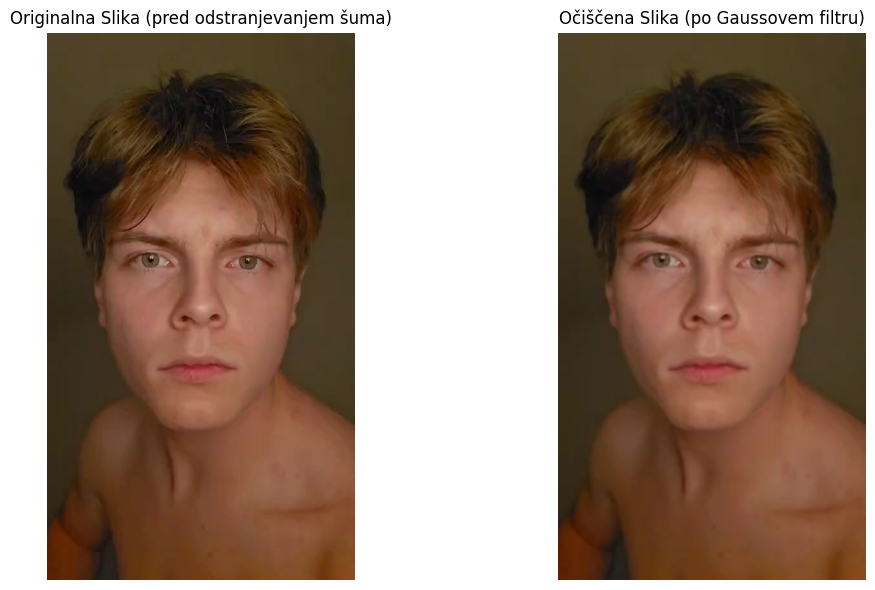

In [13]:
# Definiramo mapo z originalnimi frejmi in mapo za očiščene frejme
input_frames_folder = output_frames_folder # To so frejmi, ki smo jih ravnokar ekstrahirali
output_cleaned_folder = 'data/intermediate/oseba_1_cleaned/'

# Pripravimo mapo za očiščene frejme
if os.path.exists(output_cleaned_folder):
    shutil.rmtree(output_cleaned_folder)
os.makedirs(output_cleaned_folder, exist_ok=True)

all_frames = sorted(os.listdir(input_frames_folder))
example_original_image_rgb = None
example_cleaned_image_rgb = None
example_processed = False # Zastavica, da prikažemo samo en primer

print(f"Začenjam z odstranjevanjem šuma iz {len(all_frames)} slik...")

for i, frame_name in enumerate(all_frames):
    frame_path = os.path.join(input_frames_folder, frame_name)
    image_bgr = cv2.imread(frame_path)

    if image_bgr is None:
        print(f"Opozorilo: Slike ni mogoče naložiti: {frame_path}. Preskakujem.")
        continue

    # OpenCV bere BGR, MediaPipe in Matplotlib pa pričakujeta RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # --- Uporabimo Gaussov filter za odstranjevanje šuma ---
    # Jedro (kernel size) 5x5 je dobra začetna točka. Boljše vrednosti lahko preizkusim kasneje.
    # Večje jedro pomeni boljše zglajevanje, a tudi večjo izgubo detajlov.
    cleaned_image_rgb = cv2.GaussianBlur(image_rgb, (5, 5), 0)

    # Shranimo očiščeno sliko v novo mapo
    cleaned_frame_filename = os.path.join(output_cleaned_folder, f"cleaned_{frame_name}")
    cv2.imwrite(cleaned_frame_filename, cv2.cvtColor(cleaned_image_rgb, cv2.COLOR_RGB2BGR))

    # Shrani en primer za prikaz
    if not example_processed:
        example_original_image_rgb = image_rgb
        example_cleaned_image_rgb = cleaned_image_rgb
        example_processed = True # Po prvem primeru nastavimo na True, da ne shranjujemo več

print(f"Končano odstranjevanje šuma. Očiščene slike shranjene v: {output_cleaned_folder}")

# --- Prikaz enega primera očiščene slike ---
if example_original_image_rgb is not None:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(example_original_image_rgb)
    plt.title('Originalna Slika (pred odstranjevanjem šuma)')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(example_cleaned_image_rgb)
    plt.title('Očiščena Slika (po Gaussovem filtru)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Ni bilo slik za obdelavo ali prikaz primera.")

## Definicija funkcij za augmentacijo

In [14]:
def augment_rotate(image, angle_range=(-30, 30)):
    """
    Ročna augmentacija: Rotacija slike.
    Poudarek: Ne uporabljam visokonivojskih knjižnic za rotacijo, ampak osnovne matrične transformacije.
    """
    angle = random.randint(angle_range[0], angle_range[1]) # Naključni kot rotacije
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # Izračunamo rotacijsko matriko
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    # Izvedemo rotacijo. Previdno: nekateri piksli se lahko izgubijo na robovih.
    rotated = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    return rotated

def augment_flip(image):
    """
    Ročna augmentacija: Horizontalno zrcaljenje (flip).
    To je super, ker se obraz zrcali, kar je pogosto in ustvari novo varianto.
    """
    # 1 pomeni horizontalno zrcaljenje
    flipped = cv2.flip(image, 1)
    return flipped

def augment_brightness_contrast(image, alpha_range=(0.6, 1.4), beta_range=(-40, 40)):
    """
    Ročna augmentacija: Sprememba svetlosti in kontrasta.
    To mi pomaga simulirati različne svetlobne pogoje.
    alpha = faktor za kontrast (1.0 je original)
    beta = faktor za svetlost (0 je original)
    """
    alpha = random.uniform(alpha_range[0], alpha_range[1])
    beta = random.randint(beta_range[0], beta_range[1])

    # Uporabim np.clip, da ohranim vrednosti pikslov med 0 in 255
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

def augment_add_noise(image, noise_factor=0.003):
    """
    Ročna augmentacija: Dodajanje Gaussovega šuma.
    To je kontroliran šum, da model postane robusten na določene motnje v realnosti.
    Ne gre za odstranjevanje šuma, ampak za dodajanje.
    """
    mean = 0
    # Standardni odklon šuma, ki ga bom dodal. Pomembno: ne pretiravam!
    sigma = noise_factor * 255
    
    # Ustvarim matriko šuma z enakimi dimenzijami kot slika
    gauss = np.random.normal(mean, sigma, image.shape).astype('uint8')
    
    # Dodam šum na sliko. Uporabim cv2.add za pravilno seštevanje pikslov.
    noisy_image = cv2.add(image, gauss)
    return noisy_image

# Seznam vseh augmentacijskih funkcij in njihovih opisov
augmentations = [
    (augment_rotate, "Rotacija"),
    (augment_flip, "Horizontalno Zrcaljenje"),
    (augment_brightness_contrast, "Sprememba Svetlosti/Kontrasta"),
    (augment_add_noise, "Dodajanje Gaussovega Šuma")
]

## Izvedba augmentacij na vseh očiščenih slikah

In [15]:
# Pot do mape, kamor bom shranil vse augmentirane slike
output_augmented_folder = 'data/augmented/oseba_1_augmented/'

# Najprej poskrbim, da je mapa za augmentirane slike prazna, ali pa jo ustvarim
if os.path.exists(output_augmented_folder):
    shutil.rmtree(output_augmented_folder)
os.makedirs(output_augmented_folder, exist_ok=True)

all_cleaned_frames = sorted(os.listdir(output_cleaned_folder))
total_original_frames = len(all_cleaned_frames)
total_augmented_images = 0 # Stevec za vse augmentirane slike, vključno z originali

print(f"Začenjam z augmentacijo {total_original_frames} očiščenih slik iz '{output_cleaned_folder}'...")

# Pripravim si listo za shranjevanje primerov, da jih na koncu prikažem
display_examples = []
example_limit = 5 # Prikazal bom original in 4 augmentirane verzije

for i, frame_name in enumerate(all_cleaned_frames):
    frame_path = os.path.join(output_cleaned_folder, frame_name)
    image_bgr = cv2.imread(frame_path)

    if image_bgr is None:
        print(f"Opozorilo: Slike ni mogoče naložiti: {frame_path}. Preskakujem.")
        continue

    # Pretvorim v RGB, ker je to moj delovni barvni model
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # --- Shranim originalno očiščeno sliko ---
    # Tudi originalna očiščena slika je del nabora podatkov
    original_augmented_filename = os.path.join(output_augmented_folder, f"aug_original_{frame_name}")
    cv2.imwrite(original_augmented_filename, cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))
    total_augmented_images += 1
    if len(display_examples) < example_limit:
        display_examples.append(('Originalna', image_rgb))


    # --- Izvedem vsako augmentacijo in shranim rezultate ---
    for j, (augment_func, aug_name) in enumerate(augmentations):
        augmented_image = augment_func(image_rgb)
        
        # Shranim augmentirano sliko
        augmented_filename = os.path.join(output_augmented_folder, f"aug_{j}_{frame_name}")
        cv2.imwrite(augmented_filename, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))
        total_augmented_images += 1

        if len(display_examples) < example_limit:
            display_examples.append((aug_name, augmented_image))


print(f"Končana augmentacija. Ustvarjenih skupaj {total_augmented_images} slik. Shranjene v: {output_augmented_folder}")

Začenjam z augmentacijo 76 očiščenih slik iz 'data/intermediate/oseba_1_cleaned/'...
Končana augmentacija. Ustvarjenih skupaj 380 slik. Shranjene v: data/augmented/oseba_1_augmented/


## Prikaz primerov augmentiranih slik

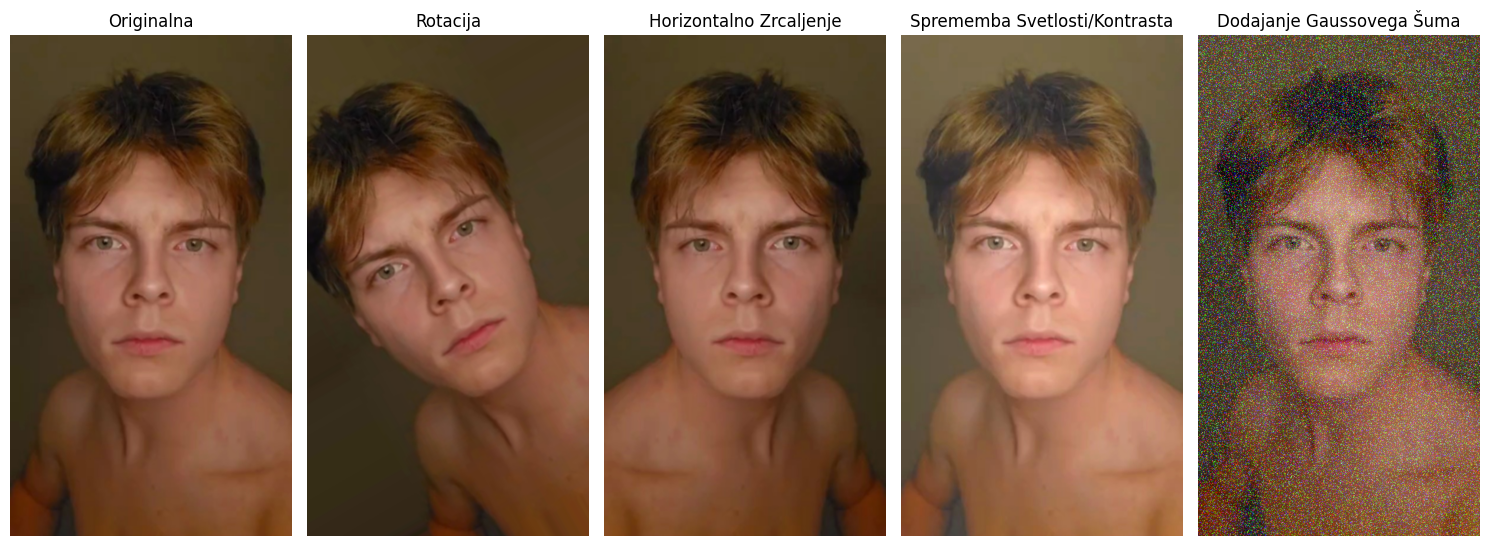

In [16]:
if display_examples:
    plt.figure(figsize=(15, 8)) # Ustvarim veliko figuro za prikaz vseh primerov
    for k, (title, img) in enumerate(display_examples):
        if k >= example_limit: # Prikazujem le določeno število primerov
            break
        plt.subplot(1, example_limit, k + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Ni primerov za prikaz. Preveri, ali so bile slike obdelane.")

## MediaPipe obrazna prepoznava in izrez

Zdaj, ko imam očiščene in augmentirane slike, je čas za ključen korak: zaznavanje obraza, poravnavo in izrezovanje z uporabo Googlove knjižnice MediaPipe. To bom naredil, da zagotovim, da so vsi obrazi v mojem naboru podatkov standardizirani – enake velikosti, pravilno poravnani (npr. oči v liniji) in brez nepotrebnega ozadja. To je nujno, da bo moj TensorFlow/Keras model kasneje deloval čim bolj natančno.

### Inicializacija MediaPipe Face Detection

In [17]:
# Inicializiramo modul za zaznavanje obraza iz MediaPipe
# model_selection=1 pomeni boljši model za daljše razdalje (celotno sliko), 0 je za bližnje obraze
# min_detection_confidence=0.7 pomeni, da zaznavanje mora biti vsaj 70% prepričano, da je to obraz
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.7)

print("MediaPipe Face Detection modul inicializiran.")

MediaPipe Face Detection modul inicializiran.


I0000 00:00:1748443768.126074 3612694 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro


## Funkcije za izrezovanje obraza

In [18]:
def crop_face_only(image, detection, target_size=(224, 224), margin_factor=1.5):
    """
    Izreže zaznan obraz brez poravnave.
    target_size: Želena velikost končne obrezane slike (npr 224x224).
    margin_factor: Faktor za razširitev bounding boxa, da zajame tudi okolico obraza.
    """
    h, w, _ = image.shape
    
    # Pridobimo podatke o zaznavi obraza
    location_data = detection.location_data
    relative_bounding_box = location_data.relative_bounding_box

    # Izračunamo absolutne koordinate bounding boxa
    xmin = int(relative_bounding_box.xmin * w)
    ymin = int(relative_bounding_box.ymin * h)
    box_width = int(relative_bounding_box.width * w)
    box_height = int(relative_bounding_box.height * h)

    xmax = xmin + box_width
    ymax = ymin + box_height

    # Dodamo malo roba okoli obraza, da zajamemo tudi čelo in brado
    # Center boxa
    center_x = (xmin + xmax) / 2
    center_y = (ymin + ymax) / 2
    
    # Upoštevamo širino in višino zaznanega obraza za rob
    # Povečamo dimenzijo, ki je večja (širina ali višina), za ohranjanje razmerja
    max_dim = max(box_width, box_height) * margin_factor
    
    # Izračunamo nove koordinate z robom
    x1 = int(center_x - max_dim / 2)
    y1 = int(center_y - max_dim / 2)
    x2 = int(center_x + max_dim / 2)
    y2 = int(center_y + max_dim / 2)

    # Poskrbimo, da koordinate ne gredo čez meje slike
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(w, x2)
    y2 = min(h, y2)

    # Končno izreži sliko
    cropped_face = image[y1:y2, x1:x2]
    
    # Preverimo, če je obrezana slika veljavna
    if cropped_face.shape[0] == 0 or cropped_face.shape[1] == 0:
        return None, (0, 0, 0, 0) # Vrni None, če je slika prazna

    # Končno spremenimo velikost na želeno ciljno velikost
    final_face = cv2.resize(cropped_face, target_size, interpolation=cv2.INTER_AREA)

    return final_face, (xmin, ymin, xmax, ymax) # Vrnem tudi originalni bounding box za prikaz

## Obdelava vseh augmentiranih slik z MediaPipe

In [19]:
# Pot do augmentiranih slik (ki so bile očiščene in augmentirane v prejšnjih korakih)
input_augmented_folder = 'data/augmented/oseba_1_augmented/'
# Pot do mape, kamor bom shranil končno obdelane obraze
output_processed_faces_folder = 'data/processed/oseba_1/'

# Pripravim izhodno mapo
if os.path.exists(output_processed_faces_folder):
    shutil.rmtree(output_processed_faces_folder)
os.makedirs(output_processed_faces_folder, exist_ok=True)

all_augmented_images = sorted(os.listdir(input_augmented_folder))
total_processed_faces = 0
examples_for_display = []
unprocessed_images_for_display = [] # <--- NOV SEZNAM ZA NEZAZNANE SLIKE
display_limit = 3 # Prikazal bom nekaj primerov za vsako fazo


print(f"Začenjam z obdelavo {len(all_augmented_images)} augmentiranih slik z MediaPipe...")

for i, image_name in enumerate(all_augmented_images):
    image_path = os.path.join(input_augmented_folder, image_name)
    image_bgr = cv2.imread(image_path)

    if image_bgr is None:
        print(f"Opozorilo: Slike ni mogoče naložiti: {image_path}. Preskakujem.")
        continue

    # MediaPipe pričakuje RGB sliko
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # --- Zaznavanje obraza z MediaPipe ---
    results = face_detection.process(image_rgb)

    # Preverim, če je MediaPipe zaznal kakšen obraz
    if results.detections:
        for detection in results.detections:
            # Izreži obraz (brez poravnave)
            processed_face, bbox = crop_face_only(image_rgb, detection, target_size=(224, 224))
            
            if processed_face is None: # Preverim, če je bilo uspešno obrezano
                print(f"Opozorilo: Obraz v sliki {image_name} ni bil pravilno obdelan (morda preveč majhen ali izven meja). Preskakujem.")
                # Shranim v seznam nezaznanih, če je bila težava pri obdelavi po zaznavi
                if len(unprocessed_images_for_display) < display_limit:
                    unprocessed_images_for_display.append({'name': image_name, 'image': image_rgb.copy()})
                continue

            # Shranim obdelan obraz
            processed_face_filename = os.path.join(output_processed_faces_folder, f"face_{i}_{image_name}")
            cv2.imwrite(processed_face_filename, cv2.cvtColor(processed_face, cv2.COLOR_RGB2BGR))
            total_processed_faces += 1

            # Shranim primer za prikaz
            if len(examples_for_display) < display_limit:
                # Naredim kopijo originalne slike za risanje bounding boxa, da ne spreminjam originala
                image_with_bbox = image_rgb.copy()
                x_min, y_min, x_max, y_max = bbox
                cv2.rectangle(image_with_bbox, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2) # Narišem zelen pravokotnik
                
                # Dodam ključne točke za prikaz (opcijsko, a vizualno pripomore)
                for kp in detection.location_data.relative_keypoints:
                    cv2.circle(image_with_bbox, (int(kp.x * image_rgb.shape[1]), int(kp.y * image_rgb.shape[0])), 5, (255, 0, 0), -1) # Modre pike

                examples_for_display.append({
                    'original_with_bbox': image_with_bbox,
                    'processed_face': processed_face
                })
                
    else:
        # <--- TUKAJ SHRANIMO SLIKE, KJER OBRAZ SPLOH NI BIL ZAZNAN
        print(f"Opozorilo: Obraz ni zaznan v sliki: {image_name}. Preskakujem.")
        if len(unprocessed_images_for_display) < display_limit: # Omejimo število prikazanih nezaznanih
            unprocessed_images_for_display.append({'name': image_name, 'image': image_rgb.copy()})


print(f"Končana obdelava z MediaPipe. Skupaj obdelanih in shranjenih {total_processed_faces} obrazov v: {output_processed_faces_folder}")

# Pomembno: Ko sem končal, sprostim MediaPipe vir
face_detection.close()

Začenjam z obdelavo 380 augmentiranih slik z MediaPipe...
Opozorilo: Obraz ni zaznan v sliki: aug_3_cleaned_frame_0095.jpg. Preskakujem.
Opozorilo: Obraz ni zaznan v sliki: aug_3_cleaned_frame_0115.jpg. Preskakujem.
Opozorilo: Obraz ni zaznan v sliki: aug_3_cleaned_frame_0120.jpg. Preskakujem.
Opozorilo: Obraz ni zaznan v sliki: aug_3_cleaned_frame_0140.jpg. Preskakujem.
Opozorilo: Obraz ni zaznan v sliki: aug_3_cleaned_frame_0160.jpg. Preskakujem.
Opozorilo: Obraz ni zaznan v sliki: aug_3_cleaned_frame_0265.jpg. Preskakujem.
Končana obdelava z MediaPipe. Skupaj obdelanih in shranjenih 717 obrazov v: data/processed/oseba_1/


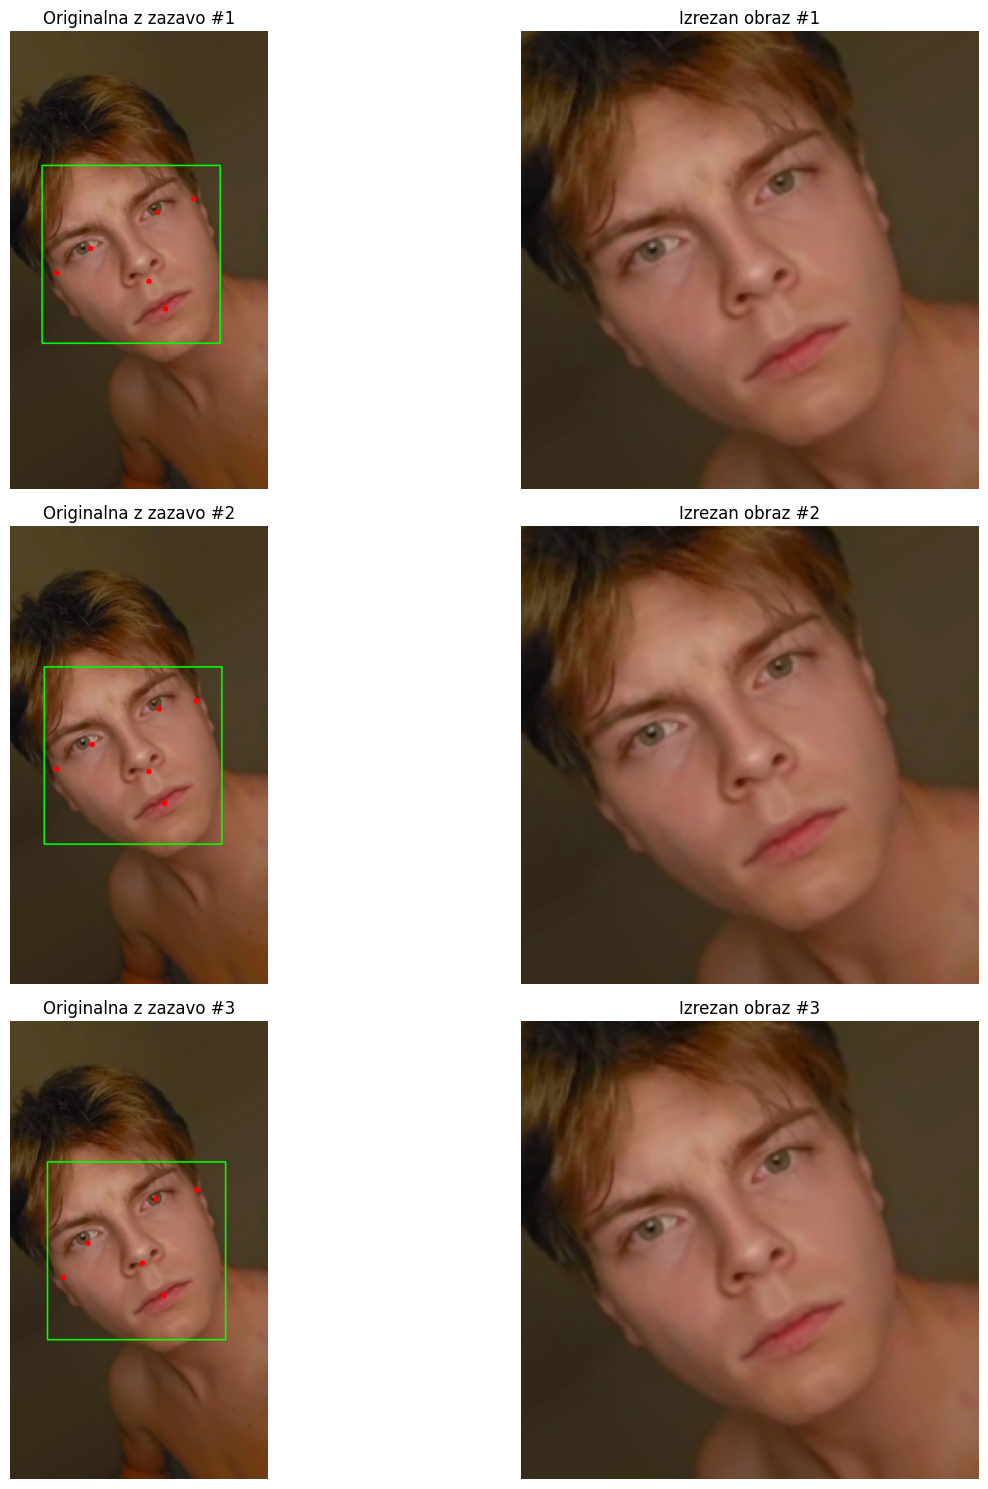


--- Slike, kjer obraz ni bil zaznan ---


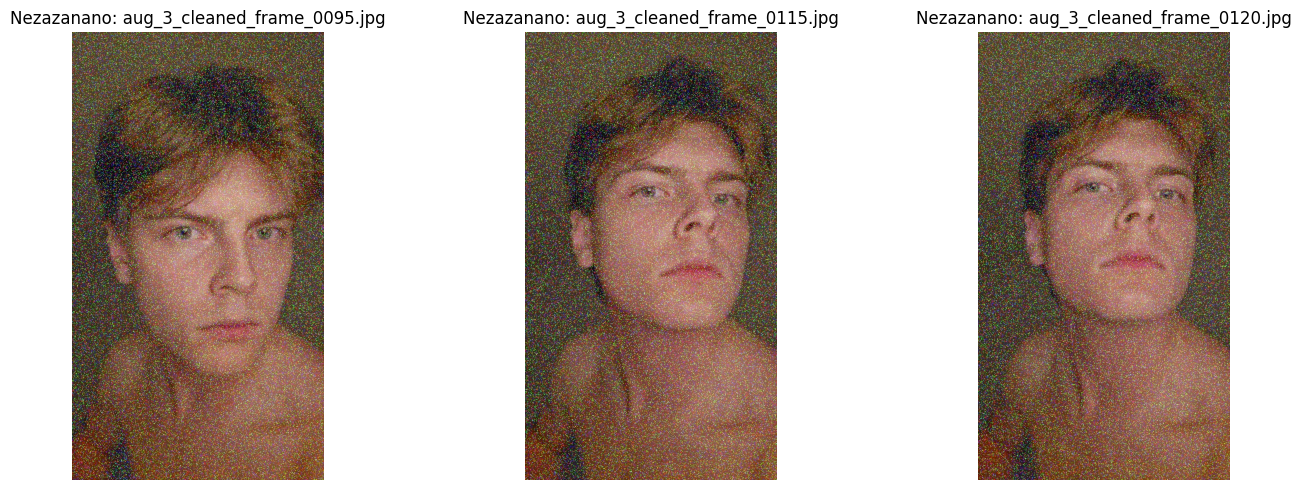

In [20]:
if examples_for_display:
    plt.figure(figsize=(15, 5 * len(examples_for_display))) # Figura za prikaz več primerov

    for idx, example in enumerate(examples_for_display):
        # Prikaz originalne slike z bounding boxom
        plt.subplot(len(examples_for_display), 2, idx * 2 + 1)
        plt.imshow(example['original_with_bbox'])
        plt.title(f'Originalna z zaznavo #{idx+1}')
        plt.axis('off')

        # Prikaz končnega obdelanega obraza
        plt.subplot(len(examples_for_display), 2, idx * 2 + 2)
        plt.imshow(example['processed_face'])
        plt.title(f'Izrezan obraz #{idx+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Ni primerov za prikaz obdelanih obrazov. Preveri, ali so bili obrazi zaznani in obdelani.")

# --- Prikaz slik, kjer obraz ni bil zaznan ---
print("\n--- Slike, kjer obraz ni bil zaznan ---")
if unprocessed_images_for_display:
    plt.figure(figsize=(15, 5 * ((len(unprocessed_images_for_display) + 2) // 3))) # Dinamična višina figure
    for idx, item in enumerate(unprocessed_images_for_display):
        plt.subplot(1, len(unprocessed_images_for_display), idx + 1)
        plt.imshow(item['image'])
        plt.title(f"Nezazanano: {item['name']}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Vse slike so bile uspešno zaznane in obdelane (ali pa ni bilo slik za obdelavo).")